In [ ]:
!pip install tensorflow
!pip install keras
!pip install numpy matplotlib

In [ ]:
!pip install opencv-python
!pip install numpy

## **1. Loading and Visualizing the Data**

In [ ]:
import os
import cv2
import numpy as np

def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray)
    return clahe_image

def preprocess_and_save_clahe(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        save_path = os.path.join(output_dir, class_name)
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is not None:
                clahe_image = apply_clahe(image)
                save_image_path = os.path.join(save_path, img_name)
                cv2.imwrite(save_image_path, clahe_image)

input_directory = '/content/drive/MyDrive/Main_Data'
output_directory = '/content/drive/MyDrive/CLAHE_Main_Data'

preprocess_and_save_clahe(input_directory, output_directory)


## **CLAHE ( Contrast and filtering )**

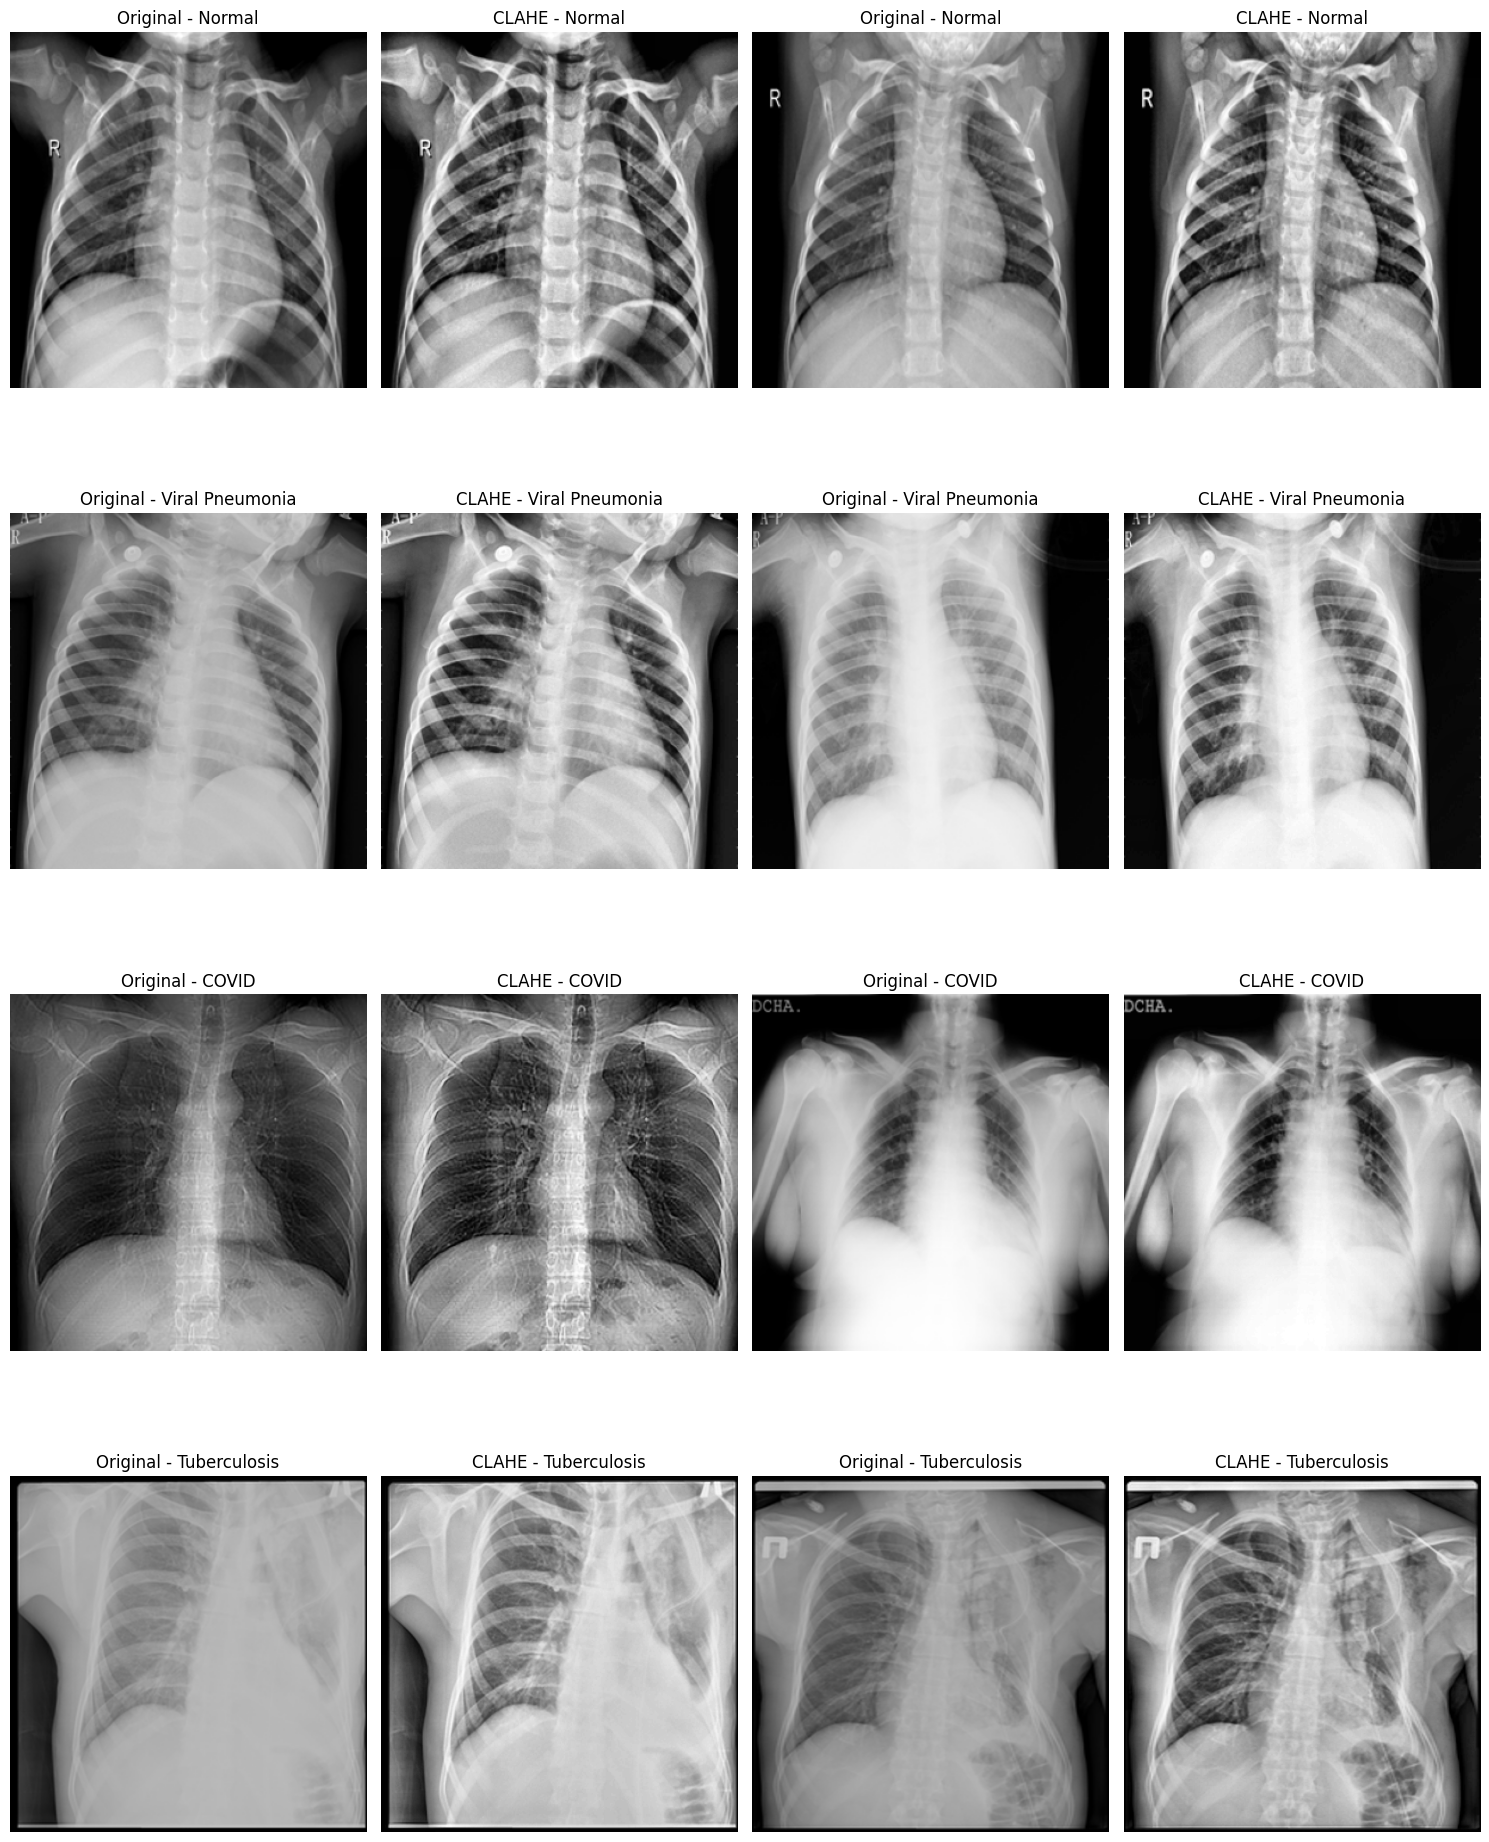

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

input_directory = '/content/drive/MyDrive/Main_Data'

def visualize_clahe_on_classes(input_dir, class_names, num_images=2):
    plt.figure(figsize=(15, len(class_names) * 5))

    image_counter = 1
    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        image_files = os.listdir(class_path)[:num_images]

        for img_name in image_files:
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)

            clahe_image = apply_clahe(image)

            plt.subplot(len(class_names), num_images * 2, image_counter)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Original - {class_name}')
            plt.axis('off')

            plt.subplot(len(class_names), num_images * 2, image_counter + 1)
            plt.imshow(clahe_image, cmap='gray')
            plt.title(f'CLAHE - {class_name}')
            plt.axis('off')

            image_counter += 2

    plt.tight_layout()
    plt.show()

class_names = ['Normal', 'Viral Pneumonia', 'COVID', 'Tuberculosis']

visualize_clahe_on_classes(input_directory, class_names)


## **Data Augmentation**

Found 1440 images belonging to 4 classes.
Found 360 images belonging to 4 classes.


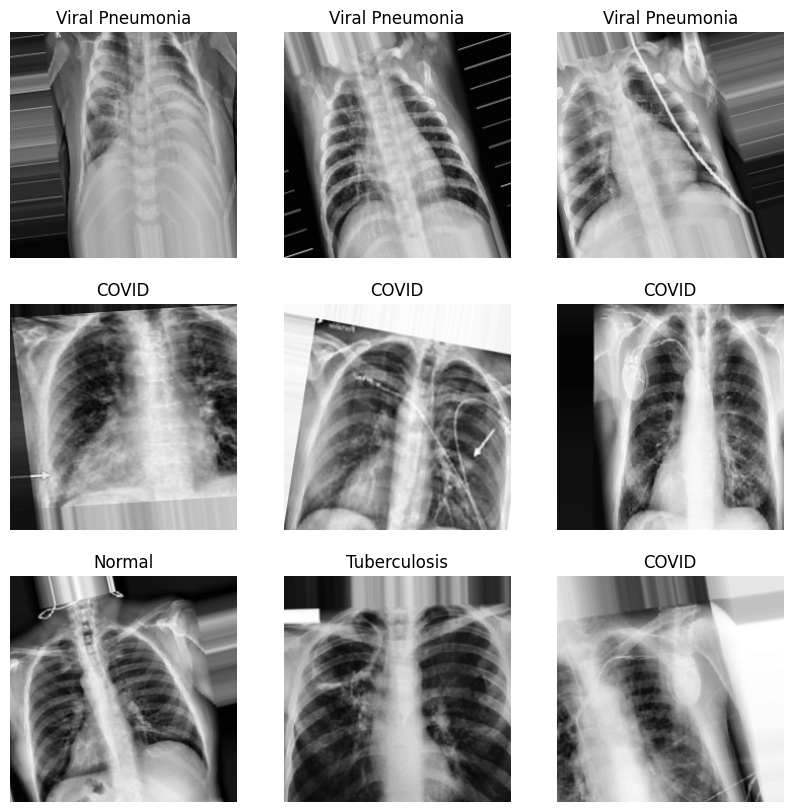

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

base_dir = '/content/drive/MyDrive/CLAHE_Main_Data'

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

def visualize_data(generator, class_names):
    batch = next(generator)
    images, labels = batch[0], batch[1]

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

class_names = list(train_generator.class_indices.keys())

visualize_data(train_generator, class_names)


## **VGGNet**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

model_vgg.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history_vgg = model_vgg.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 3430s 75s/step - accuracy: 0.5615 - loss: 1.0488 - val_accuracy: 0.7889 - val_loss: 0.6166
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3377s 75s/step - accuracy: 0.8156 - loss: 0.4997 - val_accuracy: 0.8194 - val_loss: 0.5178
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3315s 74s/step - accuracy: 0.8691 - loss: 0.3477 - val_accuracy: 0.8389 - val_loss: 0.4026
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3309s 74s/step - accuracy: 0.8674 - loss: 0.3631 - val_accuracy: 0.8361 - val_loss: 0.4741
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3279s 73s/step - accuracy: 0.8797 - loss: 0.3112 - val_accuracy: 0.8694 - val_loss: 0.3395
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3396s 75s/step - accuracy: 0.8983 - loss: 0.2776 - val_accuracy: 0.8778 - val_loss: 0.3959
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3399s 76s/step - accuracy: 0.9304 - loss: 0.2197 - val_accuracy: 0.8639 - val_loss: 0.2997
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3432s 75s/step - accuracy: 0.9327 - loss: 0.2073 - val_accuracy: 0.858

In [ ]:
model_vgg.save('/content/drive/MyDrive/lungs_modal.keras')

## **Grad-CAM Visualization**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
import tensorflow as tf

def generate_gradcam(model, img_array, layer_name):
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0].numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i].numpy()

    heatmap = np.mean(conv_outputs, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap, predicted_class

def display_gradcam(img_path, model, layer_name='block5_conv3'):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    heatmap, predicted_class = generate_gradcam(model, img_array, layer_name)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    # plt.subplot(1, 3, 2)
    # plt.imshow(heatmap)
    # plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Superimposed Image")

    plt.show()

img_path = "/content/drive/MyDrive/CLAHE_Main_Data/COVID/COVID-15.png"
display_gradcam(img_path, model_vgg, layer_name='block5_conv3')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


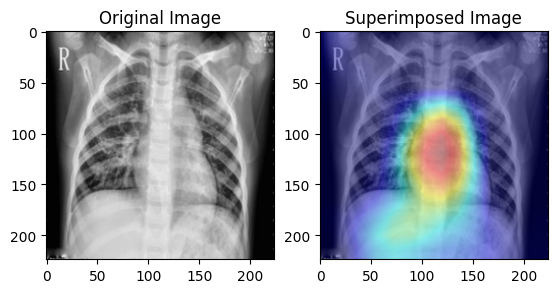

In [ ]:
img_path = "/content/drive/MyDrive/CLAHE_Main_Data/Viral Pneumonia/Viral Pneumonia-188.png"
display_gradcam(img_path, model_vgg, layer_name='block5_conv3')

In [ ]:
val_loss_vgg, val_accuracy_vgg = model_vgg.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy_vgg}')
print(f'VGGNet - Validation Loss: {val_loss_vgg}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 246s 20s/step - accuracy: 0.8950 - loss: 0.2528
VGGNet - Validation Loss: 0.27345970273017883, Validation Accuracy: 0.894444465637207


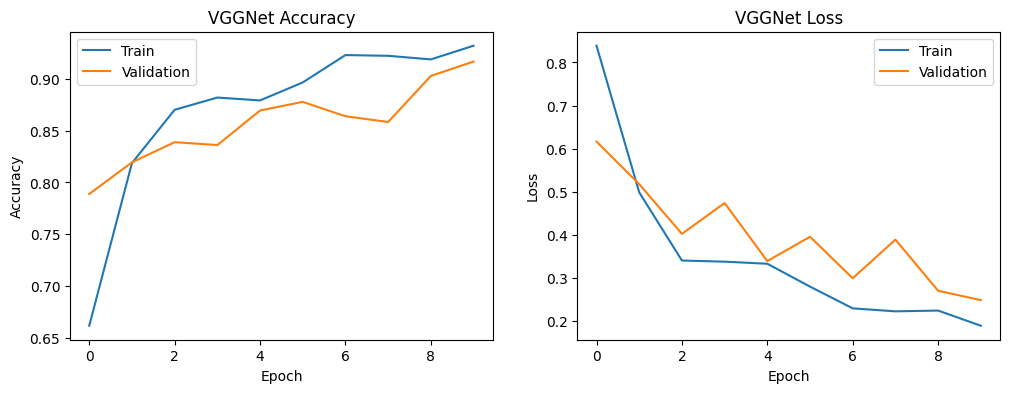

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('VGGNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('VGGNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

## **Confusion Matrix**

12/12 ━━━━━━━━━━━━━━━━━━━━ 236s 19s/step


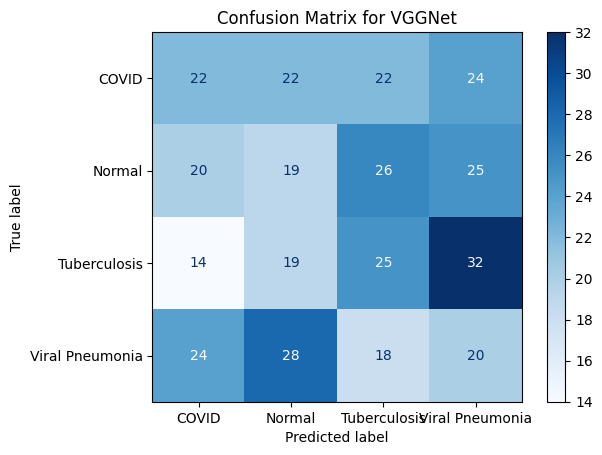

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_preds = model_vgg.predict(validation_generator)
val_preds_classes = np.argmax(val_preds, axis=1)

true_labels = validation_generator.classes

unique_classes = np.unique(true_labels)
class_names = [class_names[i] for i in unique_classes]

cm = confusion_matrix(true_labels, val_preds_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for VGGNet")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
The predicted class is: Viral Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


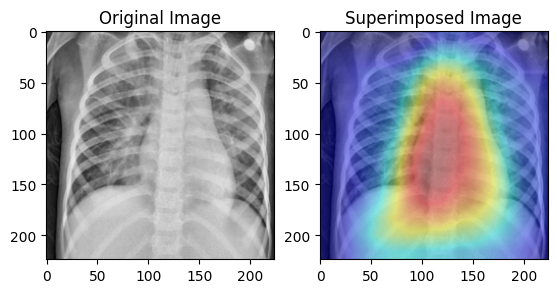

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_image_class(img_path, model):
    img_array = preprocess_image(img_path)

    predictions = model.predict(img_array)

    predicted_class_index = np.argmax(predictions)

    class_labels = [ 'COVID', 'Normal', 'Tuberculosis', 'Viral Pneumonia' ]
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label

img_path = "/content/drive/MyDrive/CLAHE_Main_Data/Viral Pneumonia/Viral Pneumonia-332.png"
predicted_label = predict_image_class(img_path, model_vgg)
print(f"The predicted class is: {predicted_label}")
display_gradcam(img_path, model_vgg, layer_name='block5_conv3')

In [ ]:
model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 45,732,302 (174.45 MB)

 Trainable params: 15,244,100 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,488,202 (116.30 MB)

## **InceptionV3**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt

In [ ]:
data_dir = '/content/drive/MyDrive/CLAHE_Main_Data'

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model_inception = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_inception.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 399s 6s/step - accuracy: 0.6060 - loss: 1.3882 - val_accuracy: 0.7232 - val_loss: 0.6756
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 437s 5s/step - accuracy: 0.8075 - loss: 0.4773 - val_accuracy: 0.7875 - val_loss: 0.5580
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 383s 5s/step - accuracy: 0.8652 - loss: 0.3468 - val_accuracy: 0.8536 - val_loss: 0.4259
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 444s 6s/step - accuracy: 0.8775 - loss: 0.3411 - val_accuracy: 0.8554 - val_loss: 0.4368
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 438s 5s/step - accuracy: 0.8958 - loss: 0.2741 - val_accuracy: 0.8714 - val_loss: 0.3934
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 379s 5s/step - accuracy: 0.8918 - loss: 0.2808 - val_accuracy: 0.8107 - val_loss: 0.5007
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 383s 5s/step - accuracy: 0.8964 - loss: 0.2590 - val_accuracy: 0.8732 - val_loss: 0.3951
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 383s 5s/step - accuracy: 0.9172 - loss: 0.2179 - val_accuracy: 0.8732 - val_loss: 0.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

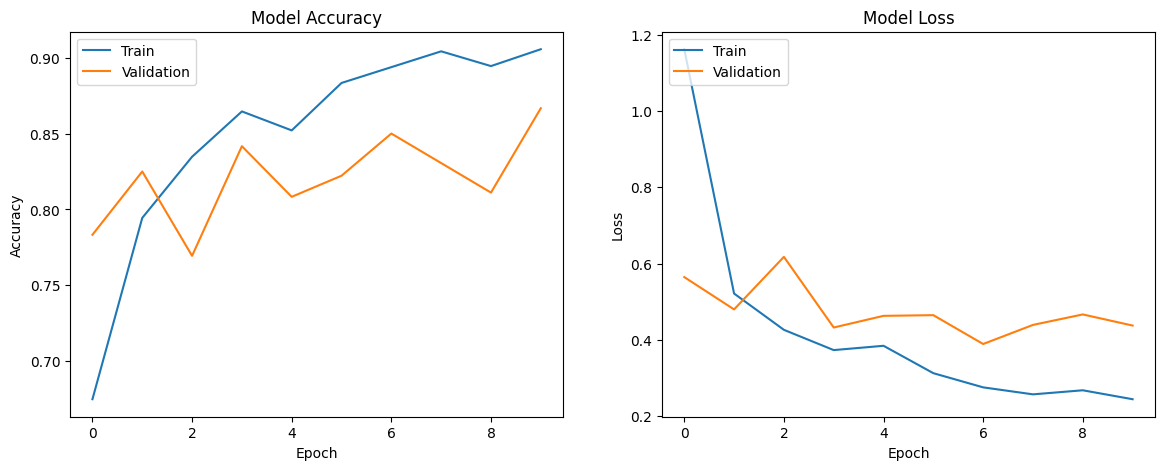

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

In [ ]:
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

model_inception.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model_inception.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 363s 8s/step - accuracy: 0.6264 - loss: 0.9605 - val_accuracy: 0.8611 - val_loss: 0.4067
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 310s 7s/step - accuracy: 0.8757 - loss: 0.3494 - val_accuracy: 0.8694 - val_loss: 0.3715
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 300s 7s/step - accuracy: 0.9416 - loss: 0.2103 - val_accuracy: 0.8694 - val_loss: 0.3402
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - accuracy: 0.9403 - loss: 0.1703 - val_accuracy: 0.8833 - val_loss: 0.3245
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 345s 7s/step - accuracy: 0.9669 - loss: 0.1203 - val_accuracy: 0.8806 - val_loss: 0.3037
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 324s 7s/step - accuracy: 0.9740 - loss: 0.0997 - val_accuracy: 0.8917 - val_loss: 0.2966
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step - accuracy: 0.9902 - loss: 0.0732 - val_accuracy: 0.8917 - val_loss: 0.2869
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 305s 7s/step - accuracy: 0.9914 - loss: 0.0597 - val_accuracy: 0.8944 - v

In [ ]:
data_path = '/content/drive/MyDrive/CLAHE_Main_Data'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of data for validation
)

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training' 
)

validation_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' 
)

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_inceptionv3_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

model.load_weights('best_inceptionv3_model.keras')

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.
Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 433s 6s/step - accuracy: 0.4206 - loss: 1.3358 - val_accuracy: 0.7304 - val_loss: 0.7437
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.7135 - loss: 0.7420 - val_accuracy: 0.7357 - val_loss: 0.6843
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 381s 5s/step - accuracy: 0.7141 - loss: 0.6668 - val_accuracy: 0.7804 - val_loss: 0.6289
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 390s 5s/step - accuracy: 0.7749 - loss: 0.5891 - val_accuracy: 0.7643 - val_loss: 0.5890
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 353s 5s/step - accuracy: 0.7783 - loss: 0.5712 - val_accuracy: 0.7679 - val_loss: 0.5847
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 365s 5s/step - accuracy: 0.8008 - loss: 0.5201 - val_accuracy: 0.7875 - val_loss: 0.5614
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 365s 5s/step - accuracy: 0.8179 - loss: 0.4881 - val_accuracy: 0.7982 - val_loss: 0.5379
Epoch 8/30
70/70 ━━━━━━━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.8650 - loss: 0.4016
Validation Accuracy: 83.93%
18/18 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step
Classification Report:
                 precision    recall  f1-score   support

          COVID       0.21      0.21      0.21       140
         Normal       0.24      0.26      0.25       140
   Tuberculosis       0.28      0.28      0.28       140
Viral Pneumonia       0.29      0.27      0.28       140

       accuracy                           0.25       560
      macro avg       0.25      0.25      0.25       560
   weighted avg       0.25      0.25      0.25       560



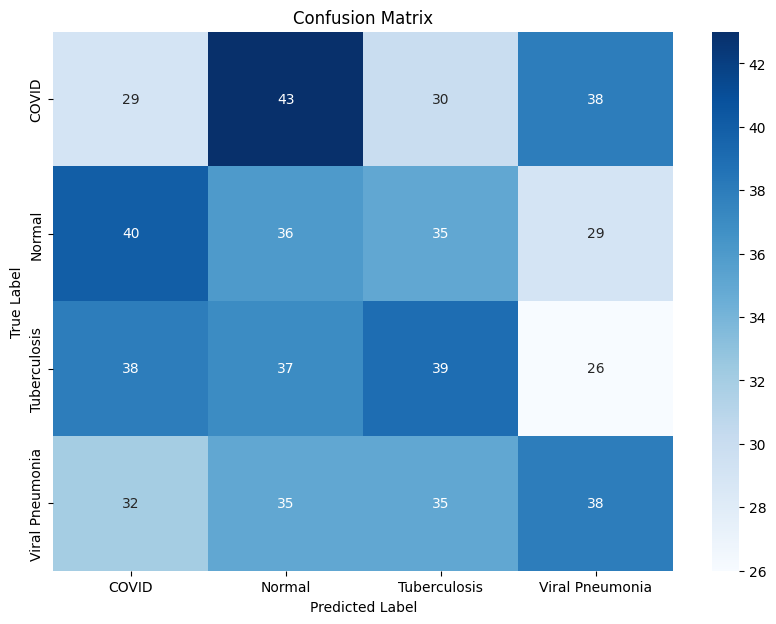

In [ ]:
val_loss, val_acc = model_inception.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

y_pred = model_inception.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Classification Report
class_labels = list(validation_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/lungs_model_inception.keras')